In [1]:
import gym
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from  ta import add_all_ta_features
%matplotlib inline


<h1>About
<h3>The Nasdaq Composite is a stock market index that includes almost all stocks listed on the Nasdaq stock exchange
The Nasdaq Stock Market  (National Association of Securities Dealers Automated Quotations Stock Market) is an American stock exchange based in New York City. <font color='red'>It is the most active stock trading venue in the US by volume</font>
<br>the Nasdaq stock contains many companies such as Apple , Microsoft and Facebook


The date - "Date" <br>

The opening price of the stock - "Open" <br>

The high price of that day - "High" <br>

The low price of that day - "Low" <br>

The closed price of that day - "Close" <br>


In [2]:
df = pd.read_csv("data/ds2.csv")
df = df[df.columns[:-2]]
df.shape

(13137, 5)

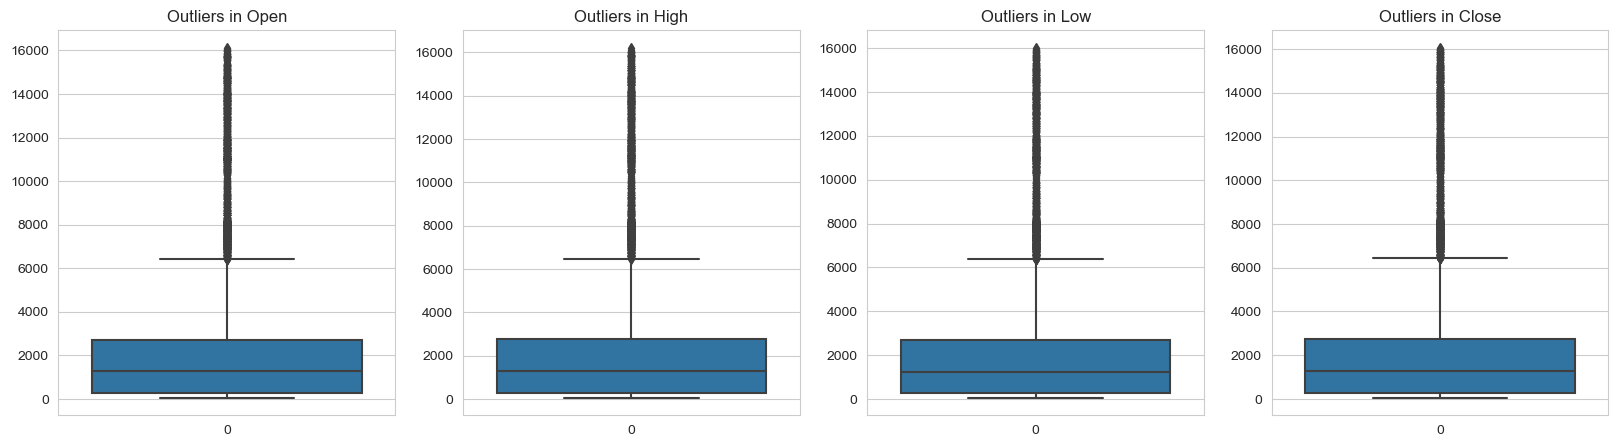

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creating a figure with 3 columns and 2 rows
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Creating a counter to keep track of the current subplot
counter = 0
data_without_name = df.drop(columns=["Date"])

# Iterating through all columns of the dataframe
for column in data_without_name.columns:
    # Create a box plot for each column
    ax = axes[counter]
    counter+=1
    sns.boxplot(df[column], ax=ax)
    ax.set_title(f"Outliers in {column}")

# Showing the plot
plt.show()


In [4]:
# Calculate the IQR
data = df.drop(columns=["Date"])

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
outliers = df[~((data[1:] < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
# Remove outliers
df.drop(df[((data[1:] < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)].index ,inplace=True ,axis=0)
print("Done")

Done


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.groupby(df['Date'].dt.year)['Open'].mean()

Date
1971     107.439301
1972     128.526614
1973     109.952857
1974      76.286877
1975      77.203952
1976      89.898103
1977      98.710119
1978     117.525119
1979     136.574545
1980     168.608379
1981     203.182371
1982     188.972886
1983     285.427786
1984     248.880079
1985     290.056746
1986     366.972529
1987     402.575888
1988     374.177471
1989     437.586508
1990     409.192965
1991     491.062016
1992     598.959410
1993     714.989645
1994     751.773848
1995     924.797660
1996    1165.113386
1997    1469.840827
1998    1794.772616
1999    2730.881518
2000    3797.171814
2001    2036.111413
2002    1541.918770
2003    1645.879645
2004    1986.853733
2005    2100.109091
2006    2263.186651
2007    2579.085580
2008    2164.308818
2009    1842.888293
2010    2348.985641
2011    2677.518578
2012    2964.836122
2013    3538.900991
2014    4375.107147
2015    4945.527375
2016    4985.953082
2017    6013.065174
2018    6278.490234
Name: Open, dtype: float64

In [6]:
df.sort_values('Date',ascending=True,inplace=True)
df.set_index('Date',inplace=True)

In [7]:
x_train , x_test =   train_test_split(df , random_state=1 , test_size=0.05)
x_train.shape , x_test.shape

((11162, 4), (588, 4))

In [13]:
env = gym.make('stocks-v0',df=x_train , window_size=30 ,frame_bound=(5,x_train.shape[0]))
env.signal_features  # Extracted features over time. Used to create Gym observations.

array([[ 14465.919922,      0.      ],
       [  3816.820068, -10649.099854],
       [ 11984.519531,   8167.699463],
       ...,
       [  1411.52002 ,   1003.820008],
       [  2018.790039,    607.270019],
       [   392.299988,  -1626.490051]])

In [14]:
env.action_space # we have 2 actions which is means sell and buy

Discrete(2)

{'total_reward': -38661.73059200002, 'total_profit': 1.779750774617987e-08, 'position': 1}


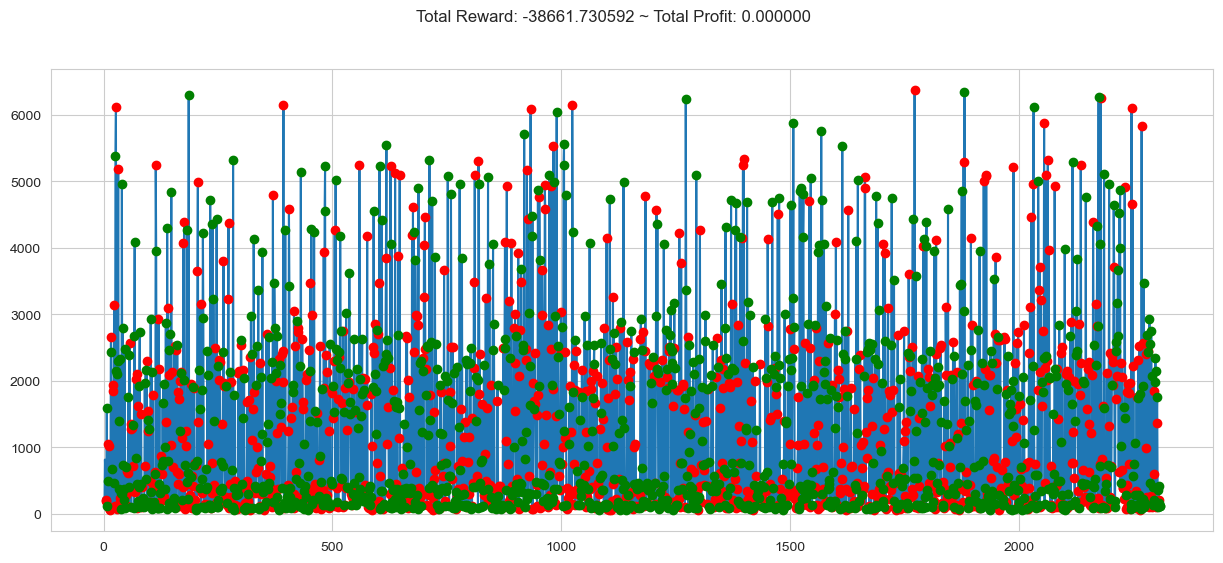

In [10]:
state = env.reset()
while True :
    action = env.action_space.sample()
    next_state,reward,done,info = env.step(action)

    if(done) :
        print(info)
        break
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [11]:
traing_env = lambda : gym.make('stocks-v0',df=x_train , window_size=5)
env = DummyVecEnv([traing_env])

In [12]:
model =A2C('MlpPolicy',env,verbose=1)
model.learn(total_timesteps=1_000_000)

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 559      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.635   |
|    explained_variance | -0.0168  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 1.16e+03 |
|    value_loss         | 1.93e+06 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 576      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.653   |
|    explained_variance | 0.0286   |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -348     |
|    value_loss      

{'total_reward': 55160.988914999994, 'total_profit': 3858803611359879.5, 'position': 0}


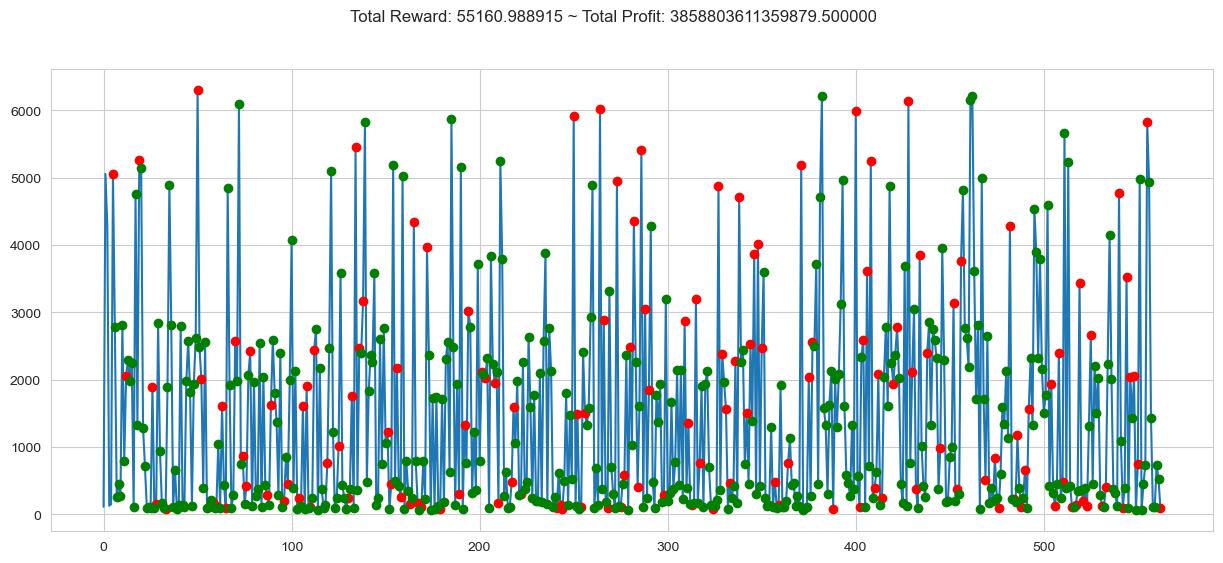

In [13]:
env = gym.make('stocks-v0',df=x_test, window_size=5)
obs = env.reset()

while True :
    obs = obs[np.newaxis,...]
    action ,states = model.predict(obs)
    obs , reward , done ,info = env.step(action)
    if done :
        print(info)
        break
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [2]:
df2 = pd.read_csv('data/^IXIC (1).csv')

In [3]:
# Calculate the IQR
data = df2.drop(columns=["Date"])

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
outliers = df2[~((data[1:] < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
# Remove outliers
df2.drop(df2[((data[1:] < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)].index ,inplace=True ,axis=0)
print("Done")

Done


In [4]:
df2  = add_all_ta_features(df2 , open='Open', high='High', low='Low',close='Close',volume='Volume',fillna=True)

C:\Users\moham\anaconda3\envs\RL_trdaer\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\moham\anaconda3\envs\RL_trdaer\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [5]:
df2.shape

(11750, 93)

In [6]:
x_train ,x_test = train_test_split(df2 , test_size=0.05 , random_state=1)

In [7]:
#
# def my_process_data(env):
#     start = env.frame_bound[0] - env.window_size
#     end = env.frame_bound[1]
#     prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
#     signal_features = env.df.loc[:, ['Close','Volume','momentum_rsi','volume_obv','trend_macd_diff']].to_numpy()[start:end]
#     return prices, signal_features
#
# class MyCustomeEnv(StocksEnv):
#     _process_data = my_process_data

In [8]:
from gym_anytrading.envs import StocksEnv

def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size
    end = frame_bound[1]
    prices = df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = df.loc[:, ['Close', 'Open', 'High', 'Low']].to_numpy()[start:end]
    return prices, signal_features


class MyStocksEnv(StocksEnv):

    def __init__(self, prices, signal_features, **kwargs):
        self._prices = prices
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._prices, self._signal_features


prices, signal_features = my_process_data(df=x_train, window_size=30, frame_bound=(30, x_train.shape[0]))
traing_env2 = MyStocksEnv(prices, signal_features, df=x_train, window_size=30, frame_bound=(30,  x_train.shape[0]))

In [9]:
env2 = lambda :MyStocksEnv(prices, signal_features, df=x_train, window_size=30, frame_bound=(30,  x_train.shape[0]))
env = DummyVecEnv([env2])

In [10]:
model =A2C('MlpPolicy',env,verbose=1)
model.learn(total_timesteps=1_000_000)

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 617      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.692   |
|    explained_variance | 0.0682   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 8.7      |
|    value_loss         | 176      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 596      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.68    |
|    explained_variance | 0.000831 |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 1.69e+03 |
|    value_loss      

In [20]:
env_test =MyStocksEnv(prices, signal_features, df=x_test, window_size=30, frame_bound=(30,  x_test.shape[0]))
obs = env_test.reset()
while True :
    action, _state = model.predict(obs, deterministic=True)
    obs , reward , done ,info = env.step(action)
    if done :
        print(info)
        break
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

NameError: name 'obss' is not defined